# Manually Parse ATL03  
Initial prototyping only
02/24/2020

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (15, 8), 'font.size': 10})

from shapely.geometry import Polygon, Point

import contextily as ctx
import h5py

import hvplot
import hvplot.pandas
import geoviews as gv

In [3]:
from icesat2_search_and_download_ATL import read_atl03
# from icesat2_search_and_download_ATL import  move_files_from_order, read_atl06, read_atl08, get_api_key
# import icesat2_search_and_download_ATL.read_atl03 as read_atl03

---

In [4]:
# icesat2_path = 'D:/wspace/icesat2/alaska'
# icesat2_path = 'test_data'
# icesat2_path = f'/fs/project/howat.4/yadav.111/icesat2/ic2' #greenland
icesat2_path = 'D:/icesat2/ic2'

In [5]:
files = os.listdir(f'{icesat2_path}')
# files
hdf_files = [f for f in files if f.endswith('.h5') and 'ATL03' in f]#[f for f in files if f.endswith('.h5')]
hdf_files

FileNotFoundError: [Errno 2] No such file or directory: 'D:/icesat2/ic2'

In [ ]:
# Get file size for granules 
sz_list = [os.path.getsize(f'{icesat2_path}/{hdf}') for hdf in hdf_files]
idx = sz_list.index(max(sz_list)) #largest index
print(len(hdf_files))


In [8]:
np.array(sz_list)/1e9

array([2.35718666, 1.25600427, 2.07051964, 3.63251772])

In [9]:
hdf_files[1]

'ATL03_20181115054039_07270105_002_01.h5'

In [10]:
hdf_path = hdf_path = f'{icesat2_path}/{hdf_files[1]}'

In [11]:
# To parse
# read_atl03(hdf_path)

In [12]:
## Read the parsed csv files

In [13]:
files = os.listdir(f'{icesat2_path}')
csv_files = [f for f in files if f.endswith('.csv') and 'ATL03' in f]#[f for f in files if f.endswith('.h5')]
csv_files

['ATL03_20181115054039_07270105_002_01_gt1l.csv',
 'ATL03_20181115054039_07270105_002_01_gt1r.csv',
 'ATL03_20181115054039_07270105_002_01_gt2l.csv',
 'ATL03_20181115054039_07270105_002_01_gt2r.csv',
 'ATL03_20181115054039_07270105_002_01_gt3l.csv',
 'ATL03_20181115054039_07270105_002_01_gt3r.csv']

In [14]:
# gt1l = pd.read_csv(f'{icesat2_path}/{csv_files[0]}')
gt1r = pd.read_csv(f'{icesat2_path}/{csv_files[1]}')
# gt2l = pd.read_csv(f'{icesat2_path}/{csv_files[2]}')
# gt2r = pd.read_csv(f'{icesat2_path}/{csv_files[4]}')


In [15]:
# gt1r.h_li.plot(kind='hist', bins=100);

In [16]:
gt1r.iloc[::10000].hvplot.scatter(x='lat', y='h_li')

:Scatter   [lat]   (h_li)

In [17]:
# gt1r.iloc[::10000].hvplot.scatter(x='lon', y='h_li')

In [18]:
# gt1l.iloc[::100000].hvplot.scatter(x='lon', y='lat')

In [25]:
# Create shapefile for a subset (1 or 0.1% of all points to get the overview of points
step = int(len(gt1r)/10000)
if step < 1:
    # to guard against very small datasets
    step = 1
gdf = gt1r.iloc[::step]
gdf['geometry'] = gdf[['lon', 'lat']].apply(lambda x: Point(x), axis=1) #because this takes a long time
gdf = gpd.GeoDataFrame(gdf[['h_li', 'geometry']], geometry='geometry')
gdf.crs = {'init': 'epsg:4326'} #not yet verified or checked with what ICESAT-2 metadata provides
type(gdf)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


geopandas.geodataframe.GeoDataFrame

In [21]:
df = gt1r
# df.head()

In [22]:
base = gv.tile_sources.ESRI
gtracks = gdf.hvplot(geo=True, alpha=0.7, width=500, height=700)
terrain_scatter = df.iloc[::step].hvplot(y='lat', x='h_li', kind='scatter', width=350, height=650, color='brown', s=20, alpha=.9).relabel('GroundTrack') 


In [24]:
base * gtracks + terrain_scatter

:Layout
   .Overlay.I           :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [Longitude,Latitude]
   .Scatter.GroundTrack :Scatter   [h_li]   (lat)

In [15]:
df['coord'] = df[['lon', 'lat']].apply(lambda x: Point(x), axis=1) #Most time consuming so far

In [17]:
gdf = gpd.GeoDataFrame(df[['h_li', 'coord']], geometry='coord')
#gdf['t_dt'] = gdf['t_dt'].dt.strftime('%Y-%m-%d %H:%M:%S.%f') #To prevent DriverSupportError: ESRI Shapefile does not support datetime fields
gdf.crs = {'init': 'epsg:4326'} #not yet verified or checked with what ICESAT-2 metadata provides

In [ ]:
gdf.plot()

In [ ]:
ax = gdf.to_crs(epsg=3857).plot(alpha=.2) # convert to web-mercator to use contextly
# https://geopandas.org/gallery/plotting_basemap_background.html
# ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax=ax) # Also provide zoom=12
# ax.set_axis_off()


In [ ]:
# gdf.to_file(f'{icesat2_path}/{g}.shp')

In [ ]:
# gdf.hvplot(geo=True, alpha=0.7, width=500, height=700)

In [ ]:
gdf.loc[:100]

In [ ]:
for gt in res_dict.keys():
    print(gt, len(res_dict[gt]))

In [ ]:
4499103/8292493, 4377621/14860051, 4724847/18727881

In [10]:
df = res_dict['gt2l']

In [20]:
# import cudf
# !nvidia-smi

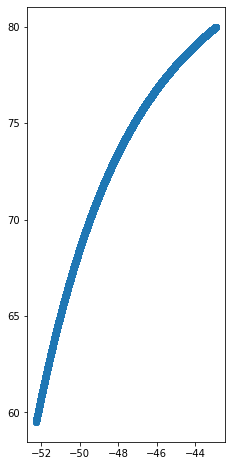

In [37]:
gdf.plot()

In [46]:
len(gdf.iloc[::100])

43777

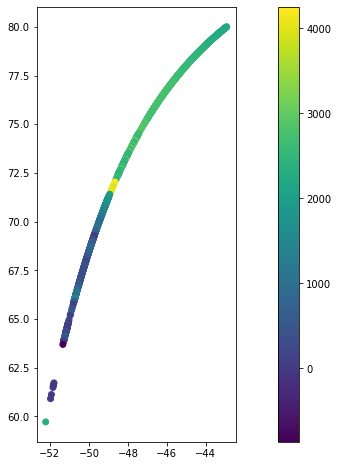

In [50]:
gdf.iloc[::5000].plot(column='h_li', legend=True)

In [52]:
gdf = gdf.iloc[::1000]

In [56]:
base = gv.tile_sources.ESRI
gtracks = gdf.hvplot.points(geo=True, alpha=0.7, width=500, height=700)

In [ ]:
# gdf1 = gdf.iloc[:100]
# gdf1.plot()

In [60]:
gdf.columns = ['h_li', 'geometry']
gdf

,h_li,geometry
0,2174.650879,POINT (-42.93015 80.00033)
1000,2174.565186,POINT (-42.93329 79.99781)
2000,2173.726562,POINT (-42.93640 79.99529)
3000,2176.954834,POINT (-42.93952 79.99277)
4000,2177.438477,POINT (-42.94247 79.99039)
...,...,...
4373000,110.371117,POINT (-52.12328 60.18117)
4374000,1939.535034,POINT (-52.19688 59.82267)
4375000,2374.092529,POINT (-52.21841 59.71643)
4376000,2385.704834,POINT (-52.22983 59.66107)


In [ ]:
terrain_scatter = df[df.strip==gtl].hvplot(y='lat', x='h_te_min', kind='scatter', width=350, height=650, color='brown', s=20, alpha=.9).relabel('terrain') # by='strip', 
canopy_scatter = df[df.strip==gtl].hvplot(y='lat', x='h_max_canopy_abs', kind='scatter', width=350, height=650, color='green', s=10, alpha=.9, title=f'Elevation ({gtl})', xlabel='meters').relabel('canopy')
fig1 = (base*gtracks + terrain_scatter*canopy_scatter).cols(2)

In [ ]:
#----------------------------------------------------------------------------------------------
# Now that ATL06 data from separate ground tracks are in one dict, merge it to df and save to csv/shp
if len(res_dict)>0:
    # 1. Combine Dataframes for each of 6 ground-tracks into single Dataframe
    count = 0
    for k in res_dict.keys():
        # k = 'gt1l', 'gt1r' etc
        if count == 0:
            df = res_dict[k]
            df['strip'] = k
            count += 1
        else:
            df1 = res_dict[k]
            df1['strip'] = k
            df = pd.concat([df, df1], axis=0)
    # Log the time range of icesat2 data (could be useful for understanding why some data is large)
    # This may be creating exception when empty
    # Choose filename for csv and shapefile
    atl_fname = os.path.splitext(hdf_path)[0].split('/')[-1]
    #df = df[df.q_flag==0] # Already done above for each ground track
    #df.to_csv(f'{icesat2_path}/{atl_fname}.csv', index=False)

    # 2. Convert to Geopandas
    df['coord'] = df[['lon', 'lat']].apply(lambda x: Point(x), axis=1)
    gdf = gpd.GeoDataFrame(df[['h_li', 'strip', 'coord']], geometry='coord')
    #gdf['t_dt'] = gdf['t_dt'].dt.strftime('%Y-%m-%d %H:%M:%S.%f') #To prevent DriverSupportError: ESRI Shapefile does not support datetime fields
    gdf.crs = {'init': 'epsg:4326'} #not yet verified or checked with what ICESAT-2 metadata provides
    #gdf.to_file(f'{icesat2_path}/{atl_fname}.shp')
    # perhaps even return df or gdf 
    #return gdf
else:
    print(f"\tNo good quality Ground Track in this HDF file; csv or shp not created")

Exception ignored in: <bound method BaseGeometry.__del__ of <shapely.geometry.point.Point object at 0x000001565F958E48>>
Traceback (most recent call last):
  File "C:\anaconda3\lib\site-packages\shapely\geometry\base.py", line 234, in __del__
    self.empty(val=None)
  File "C:\anaconda3\lib\site-packages\shapely\geometry\base.py", line 227, in empty
    self._lgeos.GEOSGeom_destroy(self.__geom__)
KeyboardInterrupt: 


In [4]:
df.hvplot(y='lat', x='lon', kind='scatter')

NameError: name 'df' is not defined

In [22]:
# gv.tile_sources.StamenTerrainRetina 
(gv.tile_sources.ESRI  * df.hvplot.points('lon', 'lat', geo=True, color='strip', alpha=0.6, width=500, height=800, hover=['strip', 'h_li']) + 
 df.hvplot(y='lat', x='h_canopy', by='q_flag', kind='scatter', height=800, alpha=.7)).cols(2)

:Layout
   .Overlay.I   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [lon,lat]   (strip)
   .NdOverlay.I :NdOverlay   [q_flag]
      :Scatter   [h_canopy]   (lat)

In [23]:
(gv.tile_sources.ESRI  * df.hvplot.points('lon', 'lat', geo=True, color='strip', alpha=0.6, width=500, height=800, hover=['strip', 'h_li']) + 
 df.hvplot(y='lat', x='h_li', by='q_flag', kind='scatter', height=800, alpha=.7)).cols(2)

:Layout
   .Overlay.I   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [lon,lat]   (strip)
   .NdOverlay.I :NdOverlay   [q_flag]
      :Scatter   [h_li]   (lat)

In [29]:
# t_diff = df.t_dt.max() - df.t_dt.min()

Timedelta('0 days 00:03:06.858000')

In [3]:
# How many minutes worth of data in the granule
# t_diff.total_seconds()/60

In [31]:
# df.to_csv('C:/temp/del.csv', index=False)

In [2]:
# gdf['t_dt'] = pd.to_datetime(gdf.t_dt)

In [1]:
# js = gdf.to_json()
# gdf.plot(column='strip', legend=True);